In [1]:
import pyspark
sc = pyspark.SparkContext()

In [2]:
from pyspark.sql import SparkSession
my_spark = SparkSession.builder.getOrCreate()
print(my_spark)

In [3]:
from pyspark.ml.classification import LogisticRegression

In [4]:
input_data = my_spark.read.csv("file:///C:/Machine Learning/AirLine Assignment/2008.csv", inferSchema =True, header = True)

In [5]:
# Filter out unimportant columns

input_data = input_data[['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'CRSDepTime',
 'ArrDelay',
 'Distance',
 'Cancelled']]

input_data.head(5)

[Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, CRSDepTime=1955, ArrDelay='-14', Distance=810, Cancelled=0),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, CRSDepTime=735, ArrDelay='2', Distance=810, Cancelled=0),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, CRSDepTime=620, ArrDelay='14', Distance=515, Cancelled=0),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, CRSDepTime=930, ArrDelay='-6', Distance=515, Cancelled=0),
 Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, CRSDepTime=1755, ArrDelay='34', Distance=515, Cancelled=0)]

In [6]:
input_data.describe

<bound method DataFrame.describe of DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, CRSDepTime: int, ArrDelay: string, Distance: int, Cancelled: int]>

In [7]:
# to drop all rows with null value
input_data.dropna().count()

7009728

In [8]:
# Assign outcome as 0 if ArrDelay <=10 or null and as 1 if ArrDelay >10
from pyspark.sql import functions
input_data = input_data.withColumn('ArrDelay',functions.when(input_data['ArrDelay']>= 10 ,1).otherwise(0))

In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [10]:
assembler = VectorAssembler(inputCols=['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'CRSDepTime',
 'ArrDelay',
 'Distance'],outputCol='features')

In [11]:
output_data=assembler.transform(input_data)

In [12]:
output_data.head()

Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, CRSDepTime=1955, ArrDelay=0, Distance=810, Cancelled=0, features=DenseVector([2008.0, 1.0, 3.0, 4.0, 1955.0, 0.0, 810.0]))

In [13]:
final_data=output_data.select('features','ArrDelay')
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- ArrDelay: integer (nullable = false)



In [14]:
train,test=final_data.randomSplit([0.8,0.2])

In [15]:
model=LogisticRegression(labelCol='ArrDelay')

In [22]:
model1=LogisticRegression(labelCol='ArrDelay')
model1=model1.fit(final_data)

In [23]:
assembler = VectorAssembler(inputCols=[
 'ArrDelay'],outputCol='feature')
test_data=assembler.transform(final_data)

In [24]:
result1=model1.transform(test_data)
result1.show()

+--------------------+--------+-------+--------------------+--------------------+----------+
|            features|ArrDelay|feature|       rawPrediction|         probability|prediction|
+--------------------+--------+-------+--------------------+--------------------+----------+
|[2008.0,1.0,3.0,4...|       0|  [0.0]|[20.9724320664647...|[0.99999999922054...|       0.0|
|[2008.0,1.0,3.0,4...|       0|  [0.0]|[16.0243696840269...|[0.99999989017413...|       0.0|
|[2008.0,1.0,3.0,4...|       1|  [1.0]|[-30.084938936953...|[8.59561650818520...|       1.0|
|[2008.0,1.0,3.0,4...|       0|  [0.0]|[16.5818305107937...|[0.99999993710697...|       0.0|
|[2008.0,1.0,3.0,4...|       1|  [1.0]|[-25.481618605750...|[8.57973056365359...|       1.0|
|[2008.0,1.0,3.0,4...|       1|  [1.0]|[-24.695806583452...|[1.88255413916576...|       1.0|
|[2008.0,1.0,3.0,4...|       1|  [1.0]|[-24.326052190687...|[2.72476948593553...|       1.0|
|[2008.0,1.0,3.0,4...|       0|  [0.0]|[17.8793495351892...|[0.9999999

In [25]:
model=model.fit(train)

In [26]:
summary=model.summary

In [27]:
summary.predictions.describe().show()

+-------+-------------------+-------------------+
|summary|           ArrDelay|         prediction|
+-------+-------------------+-------------------+
|  count|            5607761|            5607761|
|   mean|0.26903749999331283|0.26903749999331283|
| stddev| 0.4434595344101488| 0.4434595344101488|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [29]:
predictions=model.evaluate(test)

In [30]:
predictions.predictions.show()

+--------------------+--------+--------------------+--------------------+----------+
|            features|ArrDelay|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|[2008.0,1.0,1.0,2...|       1|[-33.427425825565...|[3.03845927450332...|       1.0|
|[2008.0,1.0,1.0,2...|       1|[-33.392873750581...|[3.14527914427247...|       1.0|
|[2008.0,1.0,1.0,2...|       0|[12.4774734266907...|[0.99999618845995...|       0.0|
|[2008.0,1.0,1.0,2...|       1|[-33.241432450267...|[3.65956374386239...|       1.0|
|[2008.0,1.0,1.0,2...|       0|[12.0910652664074...|[0.99999439062288...|       0.0|
|[2008.0,1.0,1.0,2...|       0|[12.3252387144962...|[0.99999556171782...|       0.0|
|[2008.0,1.0,1.0,2...|       1|[-33.237475641935...|[3.67407262166951...|       1.0|
|[2008.0,1.0,1.0,2...|       1|[-32.049423825408...|[1.20534698097325...|       1.0|
|[2008.0,1.0,1.0,2...|       0|[13.2781029467924...|[0.9999982884

In [31]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='ArrDelay')

In [32]:
evaluator.evaluate(predictions.predictions)

1.0

In [33]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

<Figure size 640x480 with 1 Axes>

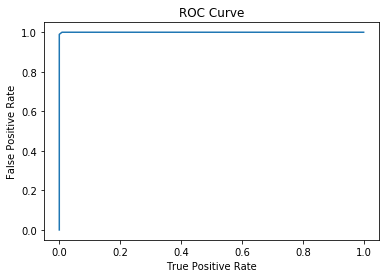

Training set areaUnderROC: 0.9999527262533925


In [34]:
# receiver-operating characteristic and areaUnderROC
import pandas as pd
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

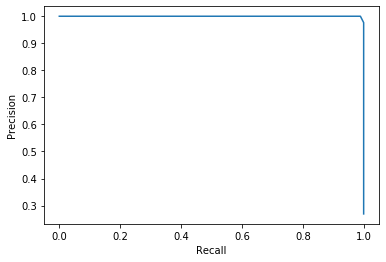

In [35]:
# Precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()